[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_3.ipynb)   
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_3.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_3.ipynb)

### based on Fig. 3 from Wojciech Grabowski and Hanna Pawlowska 2023 (Geophysical Research Letters 50(3)) 'Adiabatic Evolution of Cloud Droplet Spectral Width: A New Look at an Old Problem'

https://doi.org/10.1029/2022GL101917

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open-atmos-jupyter-utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import PySDM
print(PySDM.__file__)

/home/agnieszka/Github/PySDM/PySDM/__init__.py


In [3]:
import numpy as np
from matplotlib import pyplot
import matplotlib.ticker as ticker
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.spectra import Lognormal, Sum
from PySDM.products import (
    ParcelDisplacement, AmbientTemperature, AmbientRelativeHumidity, AmbientDryAirDensity, AmbientWaterVapourMixingRatio, ActivatedParticleConcentration,ActivatedMeanRadius,MeanVolumeRadius, AreaStandardDeviation
)

from PySDM_examples.Grabowski_and_Pawlowska_2023 import Settings, Simulation

In [4]:
settings_common={
    'dt' : 0.5 * si.s,
    'n_sd_per_mode' : (200,),
    'initial_pressure' : 900 * si.mbar,
    'initial_temperature' : 283 * si.K,
    'initial_relative_humidity' : .97,
    'displacement' : 1000 * si.m,
    'formulae' : Formulae(constants={'MAC': .3})
}
products=(
    ParcelDisplacement(
        name='z'),
    AmbientRelativeHumidity(
        name='S_max', unit='%', var='RH'),
    AmbientTemperature(
        name='T'),
    AmbientDryAirDensity(
        name='rhod'),
    AmbientWaterVapourMixingRatio(
        name='qv'),
    ActivatedParticleConcentration(
        name= 'n_act',count_activated=True,count_unactivated=False,stp=True),
    ActivatedMeanRadius(
        name= 'r_act',count_activated=True,count_unactivated=False),
    MeanVolumeRadius(
        name= 'r_vol', count_activated=True,count_unactivated=False),
    AreaStandardDeviation(
        name='area_std', count_activated=True,count_unactivated=False),
)

In [5]:
output_POL=np.array([])
output_PRI=np.array([])
legend=[]
for w in [0.25,1,4]:
    settings = Settings(  #pristine
        **settings_common,
        vertical_velocity = w * si.m / si.s,
        aerosol_modes_by_kappa = {
            1.28: Sum((
                Lognormal(norm_factor=125 / si.cm ** 3,m_mode=11 * si.nm,s_geom=1.2),
                Lognormal(norm_factor=65 / si.cm ** 3,m_mode=60 * si.nm,s_geom=1.7)
            ))
        })
    simulation = Simulation(settings, products=products)
    output_PRI = np.append(output_PRI,simulation.run())

    settings = Settings(   #polluted
        **settings_common,
        vertical_velocity = w* si.m / si.s,
        aerosol_modes_by_kappa = {
            1.28: Sum((
                Lognormal(norm_factor=160 / si.cm ** 3,m_mode=29 * si.nm,s_geom=1.36),
                Lognormal(norm_factor=380 / si.cm ** 3,m_mode=71 * si.nm,s_geom=1.57)
            ))
        })
    simulation = Simulation(settings, products=products)
    output_POL = np.append(output_POL,simulation.run())
    legend.append(str(w)+' m/s')

    

/home/agnieszka/Github/PySDM/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [6]:
def r_vol_mean(v, n, mask): 
    nt = v.shape[1] #number of timesteps
    vmean = np.full(nt, np.nan)
    n_dot_v =np.multiply(np.array(n),np.where(mask,v,0))
    n_tot = np.sum(np.where(mask, np.array(n), 0), axis=0) 
    nmask = n_tot > 0
    vmean[nmask] = np.sum(n_dot_v[:,nmask], axis=0) / n_tot[nmask]
    return settings.formulae.trivia.radius(volume=vmean)

def rmean(r, n, mask): 
    nt = r.shape[1]
    rmean = np.full(nt, np.nan)
    n_dot_r =np.multiply(np.array(n),np.where(mask,r,0))
    n_tot = np.sum(np.where(mask, np.array(n), 0), axis=0) 
    nmask = n_tot > 0
    rmean[nmask] = np.sum(n_dot_r[:,nmask], axis=0) / n_tot[nmask]
    return rmean

#TODO new test using this function
def n_act(n, mask,rhod,qv):
    mass=settings.formulae,simulation.particulator.environment.mass_of_dry_air
    density=settings.formulae.state_variable_triplet.rho_of_rhod_qv(rhod,qv)
    volume = mass[1]/density
    n_tot = np.sum(np.where(mask, np.array(n), 0), axis=0) 
    return n_tot/volume

def area_std(r, n, mask):
    nt = r.shape[1]
    n_tot = np.sum(np.where(mask, np.array(n), 0), axis=0) 
    #n_act=np.where(mask, np.array(n), np.nan)
    r_act=np.where(mask, np.array(r), np.nan)
    r_sq=np.multiply(r_act,r_act)
    area_std=np.full(nt,np.nan)
    for i in range(nt):
        if n_tot[i]>0:
            area_std[i]=np.std(r_sq[:,i][~np.isnan(r_sq[:,i])])
            #area_std[i]=np.sqrt(np.cov(r_sq[:,i][~np.isnan(r_sq[:,i])], fweights=n_act[:,i][~np.isnan(n_act[:,i])]))
    return area_std


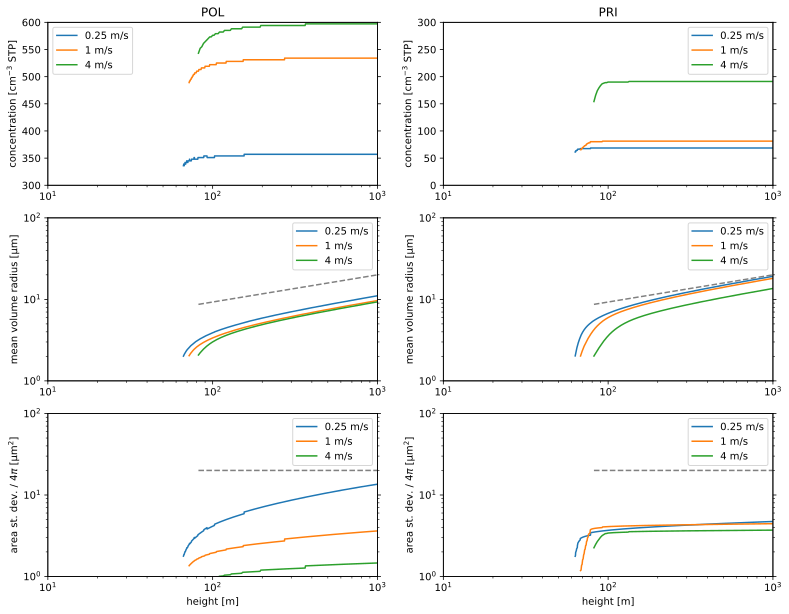

HTML(value="<a href='./fig3.pdf' target='_blank'>./fig3.pdf</a><br>")

In [7]:
fig, axs = pyplot.subplots(3, 2, sharey=False, figsize=(13, 10))
axR1 = axs[1,0]
axN1 = axs[0,0]
axA1 = axs[2,0]
for i in range(3):
    r1=np.array(output_POL[i]['products']['r_vol'])
    n1=np.array(output_POL[i]['products']['n_act'])
    a1=np.array(output_POL[i]['products']['area_std'])/(4*np.pi)
    #a1=area_std(settings.formulae.trivia.radius(volume=np.asarray(output_POL[i]['attributes']['volume'])), np.array(output_POL[i]['attributes']['n']), np.asarray(output_POL[i]['attributes']['volume'])>np.asarray(output_POL[i]['attributes']['critical volume']))
    axR1.plot(np.array(output_POL[i]['products']['z']),np.where(r1*10**6>2,r1*10**6,np.nan))
    axN1.plot(np.array(output_POL[i]['products']['z']),np.where(r1*10**6>2,n1*10**(-6),np.nan))
    axA1.plot(np.array(output_POL[i]['products']['z']),np.where(r1*10**6>2,a1*10**12,np.nan))
axR1.plot(np.array(output_POL[i]['products']['z']),np.where(r1*10**6>2,2*np.array(output_POL[i]['products']['z'])**(1/3),np.nan),color='grey',linestyle='--')
axA1.plot(np.array(output_POL[i]['products']['z']),np.where(r1*10**6>2,20,np.nan),color='grey',linestyle='--')

axR2 = axs[1,1]
axN2 = axs[0,1]
axA2 = axs[2,1]
for i in range(3):
    r2=np.array(output_PRI[i]['products']['r_vol'])
    n2=np.array(output_PRI[i]['products']['n_act'])
    a2=np.array(output_PRI[i]['products']['area_std'])/(4*np.pi)
    #a2=area_std(settings.formulae.trivia.radius(volume=np.asarray(output_PRI[i]['attributes']['volume'])), np.array(output_PRI[i]['attributes']['n']), np.asarray(output_PRI[i]['attributes']['volume'])>np.asarray(output_PRI[i]['attributes']['critical volume']))
    axR2.plot(np.array(output_PRI[i]['products']['z']),np.where(r2*10**6>2,r2*10**6,np.nan))
    axN2.plot(np.array(output_PRI[i]['products']['z']),np.where(r2*10**6>2,n2*10**(-6),np.nan))
    axA2.plot(np.array(output_PRI[i]['products']['z']),np.where(r2*10**6>2,a2*10**12,np.nan))
axR2.plot(np.array(output_PRI[i]['products']['z']),np.where(r2*10**6>2,2*np.array(output_PRI[i]['products']['z'])**(1/3),np.nan),color='grey',linestyle='--')
axA2.plot(np.array(output_PRI[i]['products']['z']),np.where(r2*10**6>2,20,np.nan),color='grey',linestyle='--')

for ax in [axN1,axN2,axR1,axR2,axA1,axA2]:
    ax.set_xlim(10,1000)
    ax.set_xscale('log')
    ax.legend(legend)
for ax in [axR1,axR2]:
    ax.set_ylabel('mean volume radius [μm]')
for ax in [axN1,axN2]:
    ax.set_ylabel('concentration [cm$^{-3}$ STP]')
for ax in [axA1,axA2]:
    ax.set_xlabel('height [m]')
    ax.set_ylabel('area st. dev. / 4$\pi$ [μm$^2$]')
axN1_ = axN1.twinx() 
axN2_ = axN2.twinx() 
axR1_ = axR1.twinx() 
axR2_ = axR2.twinx() 
axA1_ = axA1.twinx() 
axA2_ = axA2.twinx()
for ax in [axR1,axR2,axR1_,axR2_,axA1,axA2,axA1_,axA2_]:
    ax.set_yscale('log')
    ax.set_ylim(1,100)
for ax in [axN1,axN1_]:
    ax.set_ylim(300,600)
for ax in [axN2,axN2_]:
    ax.set_ylim(0,300)
axN1.set_title('POL')
axN2.set_title('PRI')
for ax in [axN1_,axN2_,axR1_,axR2_,axA1_,axA2_]:
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
show_plot("fig3.pdf")